# Importing necessary things

In [1]:
import pandas as pd
import pickle
import bz2

import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                                                            
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

------------

# Looking at the dataframe

In [2]:
# Bring dataset from pickle

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [3]:
df = decompress_pickle('data/compressedpz.pbz2')
df

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response
84652123,84652123,"{'steamid': '76561198044182675', 'num_games_ow...",english,Don't get me wrong this game is amazing. I spe...,1610600299,1610600299,False,0,0,0,0,True,False,True,NaN,NaN
84650292,84650292,"{'steamid': '76561198189260829', 'num_games_ow...",english,ME LIKE!!,1610596706,1610596706,True,0,0,0,0,True,False,True,NaN,NaN
84647357,84647357,"{'steamid': '76561197968351158', 'num_games_ow...",english,Really good game. Make sure you opt into the b...,1610591400,1610591400,True,0,0,0,0,True,False,True,NaN,NaN
84646408,84646408,"{'steamid': '76561198025117668', 'num_games_ow...",english,Project Zomboid is THE zombie survival game. W...,1610589741,1610589741,True,0,0,0,0,True,False,True,NaN,NaN
84643897,84643897,"{'steamid': '76561198024526105', 'num_games_ow...",english,Less of an action-packed zombie apocalypse gam...,1610585302,1610585302,True,0,0,0,0,True,False,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7602280,7602280,"{'steamid': '76561198067098561', 'num_games_ow...",english,This is a must buy! It's a really unique game ...,1383932465,1383932465,True,0,0,0,0,False,False,True,NaN,NaN
7602237,7602237,"{'steamid': '76561198043807990', 'num_games_ow...",english,Fans of serious zombie survival games that is ...,1383932174,1385746707,True,20,0,0.715714693069458008,0,False,False,True,NaN,NaN
7602221,7602221,"{'steamid': '76561197981939207', 'num_games_ow...",brazilian,Esse jogo é muito bacana para quem gosta de um...,1383932039,1385658239,True,23,0,0.741350948810577393,0,False,False,True,NaN,NaN
7602166,7602166,"{'steamid': '76561198024263590', 'num_games_ow...",english,"2013:After a really, really long wait it's fin...",1383931617,1575136783,True,0,0,0,0,False,False,True,NaN,NaN


------

# Cleaning the data

In [4]:
# Checking for null values
# Almost all the reviews have no responses from the dev.

df.isna().sum()

recommendationid                   0
author                             0
language                           0
review                             0
timestamp_created                  0
timestamp_updated                  0
voted_up                           0
votes_up                           0
votes_funny                        0
weighted_vote_score                0
comment_count                      0
steam_purchase                     0
received_for_free                  0
written_during_early_access        0
timestamp_dev_responded        33976
developer_response             33976
dtype: int64

In [5]:
# Dropping columns that are not particularly useful.

df = df.drop(columns=['recommendationid', 'author', 'timestamp_updated', 'timestamp_dev_responded', 'developer_response', 'written_during_early_access'])
df.head()

,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,1610600299,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,1610596706,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,1610591400,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,1610589741,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,1610585302,True,0,0,0,0,True,False


In [6]:
import time

# Changing epoch time to readable format. Removing timestamp for ease of time series.
df['timestamp_created'] = [time.strftime('%Y-%m-%d', time.localtime(x)) for x in df['timestamp_created']]
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], format='%Y-%m-%d')

# Changing name of column for ease. 
df = df.rename(columns={'timestamp_created':'reviewtimeposted'})
df

,language,review,reviewtimeposted,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,2021-01-13,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,2021-01-13,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,2021-01-13,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,2021-01-13,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,2021-01-13,True,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...
7602280,english,This is a must buy! It's a really unique game ...,2013-11-08,True,0,0,0,0,False,False
7602237,english,Fans of serious zombie survival games that is ...,2013-11-08,True,20,0,0.715714693069458008,0,False,False
7602221,brazilian,Esse jogo é muito bacana para quem gosta de um...,2013-11-08,True,23,0,0.741350948810577393,0,False,False
7602166,english,"2013:After a really, really long wait it's fin...",2013-11-08,True,0,0,0,0,False,False


-----

# Checking distribution of reviews

In [ ]:
# About half the reviews are in English as indicated by the reviewers.

df['language'].value_counts()

In [ ]:
# A large majority of people reviewed the game positively.

df['voted_up'].value_counts()

In [ ]:
# A large majority of people who made reviews purchased the game on Steam.

df['steam_purchase'].value_counts()

In [ ]:
# A vast majority of people who made reviews paid for the game.

df['received_for_free'].value_counts()

----

## Removing outliers

In [7]:
reviewcount = df['reviewtimeposted'].value_counts().rename_axis('date').reset_index(name='dailycount')
reviewcount = reviewcount.sort_values(by='date')
reviewcount.set_index('date', inplace=True)
reviewcount.head()

,dailycount
date,
2013-11-08,58
2013-11-09,46
2013-11-10,37
2013-11-11,21
2013-11-12,22


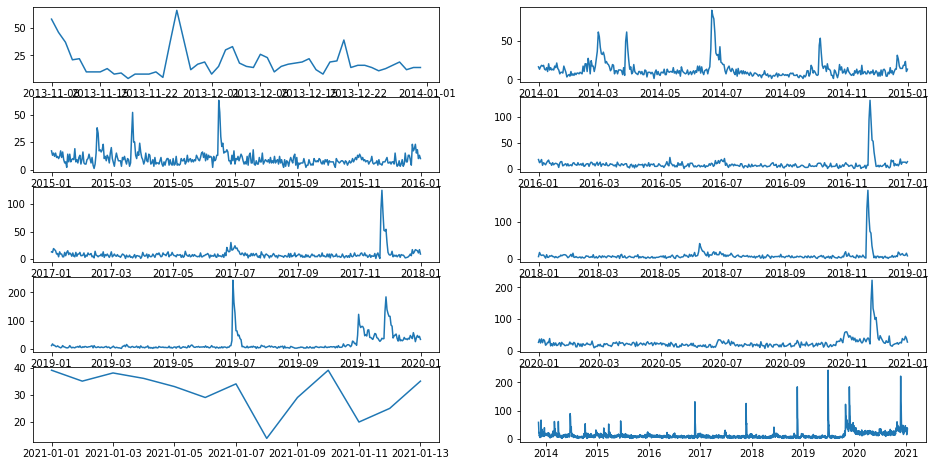

In [8]:
reviewcount13 = reviewcount['2013-01-01':'2013-12-31']
reviewcount14 = reviewcount['2014-01-01':'2014-12-31']
reviewcount15 = reviewcount['2015-01-01':'2015-12-31']
reviewcount16 = reviewcount['2016-01-01':'2016-12-31']
reviewcount17 = reviewcount['2017-01-01':'2017-12-31']
reviewcount18 = reviewcount['2018-01-01':'2018-12-31']
reviewcount19 = reviewcount['2019-01-01':'2019-12-31']
reviewcount20 = reviewcount['2020-01-01':'2020-12-31']
reviewcount21 = reviewcount['2021-01-01':'2021-12-31']

fig, axes = plt.subplots(5, 2, figsize=(16,8))

axes[0, 0].plot(reviewcount13)
axes[0, 1].plot(reviewcount14)
axes[1, 0].plot(reviewcount15)
axes[1, 1].plot(reviewcount16)
axes[2, 0].plot(reviewcount17)
axes[2, 1].plot(reviewcount18)
axes[3, 0].plot(reviewcount19)
axes[3, 1].plot(reviewcount20)
axes[4, 0].plot(reviewcount21)
axes[4, 1].plot(reviewcount)

plt.show()

In [9]:
def hampel(vals_orig, k=7, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    
    #Make copy so original not edited
    vals = vals_orig.copy()
    
    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    '''
    Perhaps a condition should be added here in the case that the threshold value
    is 0.0; maybe do not mark as outlier. MAD may be 0.0 without the original values
    being equal. See differences between MAD vs SDV.
    '''
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return(vals)

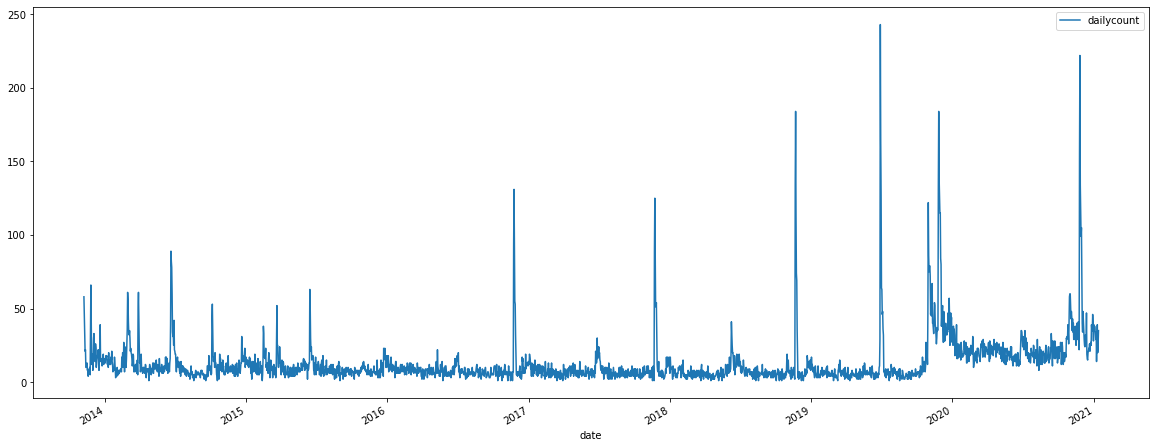

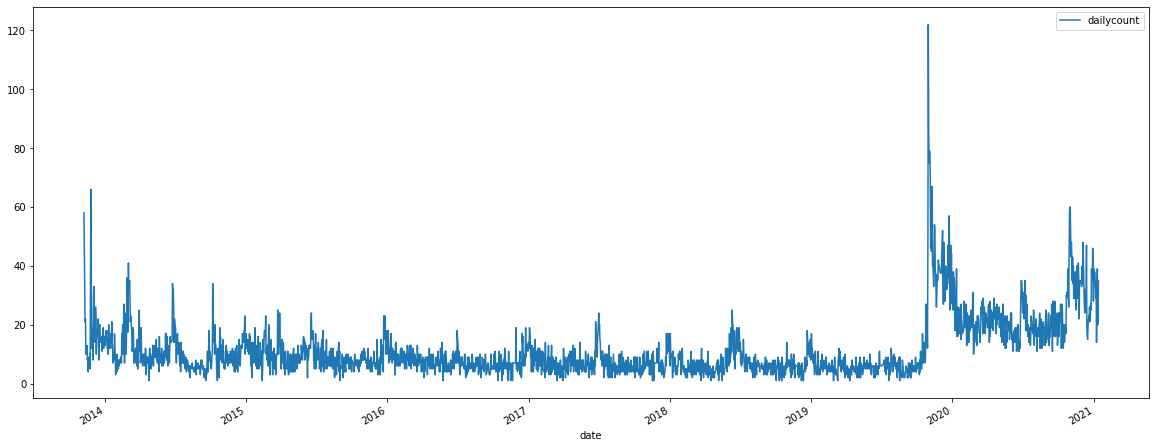

In [10]:
ts = reviewcount
hampts = hampel(ts, 40)

ts.plot(figsize = (20,8))
hampts.plot(figsize = (20,8))

plt.show()

In [11]:
list(hampts.values.flatten())

[58.0,
 46.0,
 37.0,
 21.0,
 22.0,
 10.0,
 10.0,
 10.0,
 13.0,
 8.0,
 9.0,
 4.0,
 8.0,
 8.0,
 8.0,
 10.0,
 5.0,
 36.0,
 66.0,
 39.0,
 12.0,
 17.0,
 19.0,
 8.0,
 15.0,
 30.0,
 33.0,
 18.0,
 15.0,
 14.0,
 26.0,
 23.0,
 10.0,
 15.0,
 17.0,
 18.0,
 19.0,
 22.0,
 12.0,
 8.0,
 19.0,
 20.0,
 16.0,
 14.0,
 16.0,
 16.0,
 14.0,
 11.0,
 13.0,
 16.0,
 19.0,
 12.0,
 14.0,
 14.0,
 16.0,
 13.0,
 16.0,
 18.0,
 17.0,
 18.0,
 13.0,
 12.0,
 15.0,
 10.0,
 20.0,
 12.0,
 15.0,
 12.0,
 13.0,
 12.0,
 17.0,
 15.0,
 21.0,
 14.0,
 12.0,
 7.0,
 9.0,
 9.0,
 8.0,
 17.0,
 13.0,
 9.0,
 3.0,
 5.0,
 6.0,
 4.0,
 10.0,
 5.0,
 7.0,
 5.0,
 8.0,
 6.0,
 8.0,
 8.0,
 7.0,
 9.0,
 8.0,
 7.0,
 17.0,
 10.0,
 20.0,
 20.0,
 10.0,
 27.0,
 20.0,
 7.0,
 24.0,
 17.0,
 17.0,
 10.0,
 16.0,
 26.0,
 36.0,
 17.5,
 17.5,
 41.0,
 33.0,
 32.0,
 35.0,
 30.0,
 21.0,
 23.0,
 20.0,
 19.0,
 16.0,
 11.0,
 13.0,
 19.0,
 18.0,
 7.0,
 11.0,
 11.0,
 7.0,
 12.0,
 12.0,
 12.0,
 11.0,
 6.0,
 15.0,
 5.0,
 11.5,
 11.0,
 11.0,
 25.0,
 13.0,
 16.0,
 7.0,
 9.0,


In [12]:
reviewcount['dailycountfilter'] = pd.Series(hampts.values.flatten(), index=reviewcount.index)
reviewcount

,dailycount,dailycountfilter
date,,
2013-11-08,58,58.0
2013-11-09,46,46.0
2013-11-10,37,37.0
2013-11-11,21,21.0
2013-11-12,22,22.0
...,...,...
2021-01-09,29,29.0
2021-01-10,39,39.0
2021-01-11,20,20.0


In [17]:
reviewcount['filtered'] = np.where(reviewcount['dailycount'] == reviewcount['dailycountfilter'], True, False)
reviewcount['filtered'].value_counts()

True     2505
False     110
Name: filtered, dtype: int64

----

In [18]:
reviewcountmonthly = reviewcount['dailycountfilter'].resample('MS')
month_mean = reviewcountmonthly.mean()
month_mean

date
2013-11-01    20.695652
2013-12-01    16.677419
2014-01-01    12.806452
2014-02-01    13.178571
2014-03-01    17.209677
                ...    
2020-09-01    19.166667
2020-10-01    25.258065
2020-11-01    36.366667
2020-12-01    29.870968
2021-01-01    31.230769
Freq: MS, Name: dailycountfilter, Length: 87, dtype: float64

Text(0, 0.5, 'Number of Reviews')

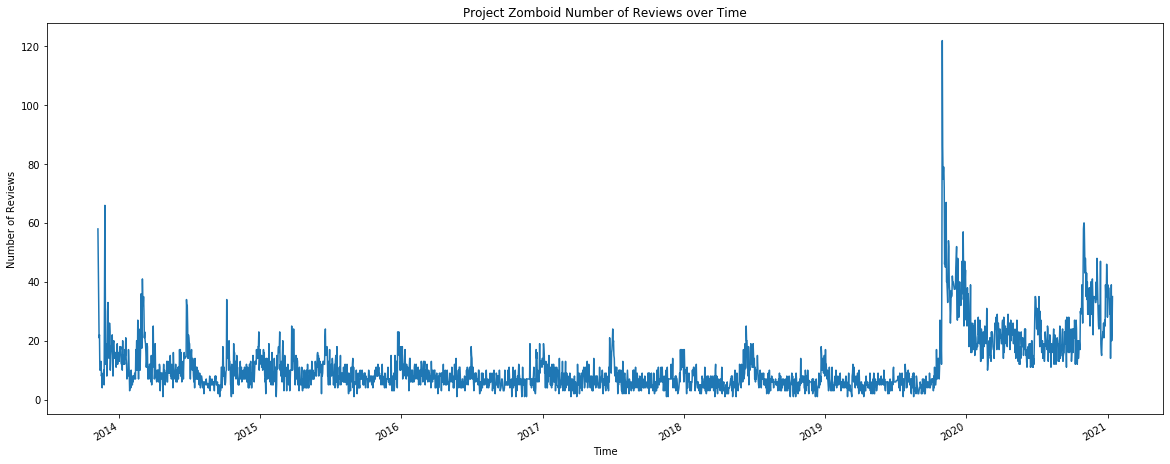

In [19]:
reviewcount['dailycountfilter'].plot(figsize = (20,8))
plt.title('Project Zomboid Number of Reviews over Time')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)

Text(0, 0.5, 'Number of Reviews')

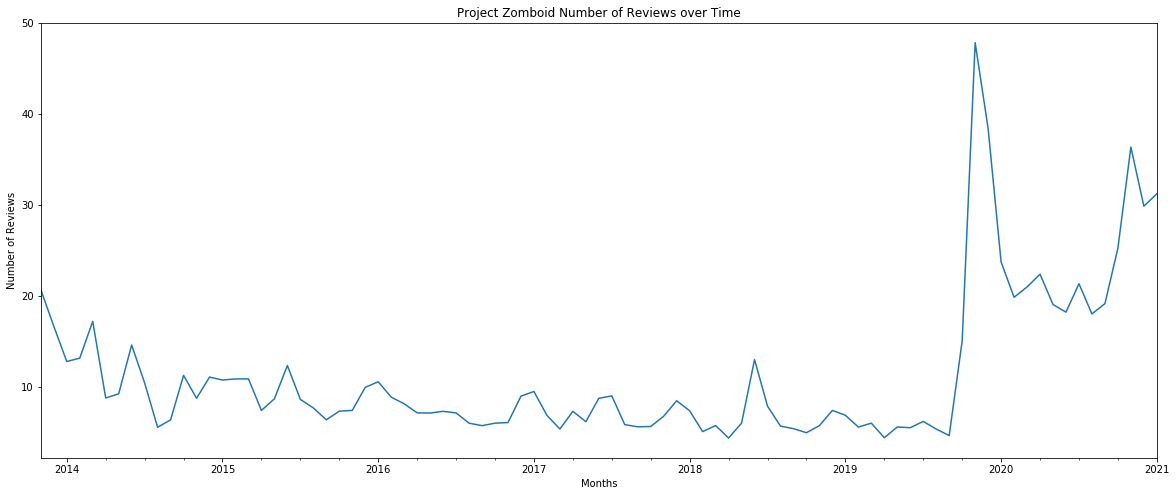

In [20]:
month_mean.plot(figsize = (20,8))
plt.title('Project Zomboid Number of Reviews over Time')
plt.xlabel('Months', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)

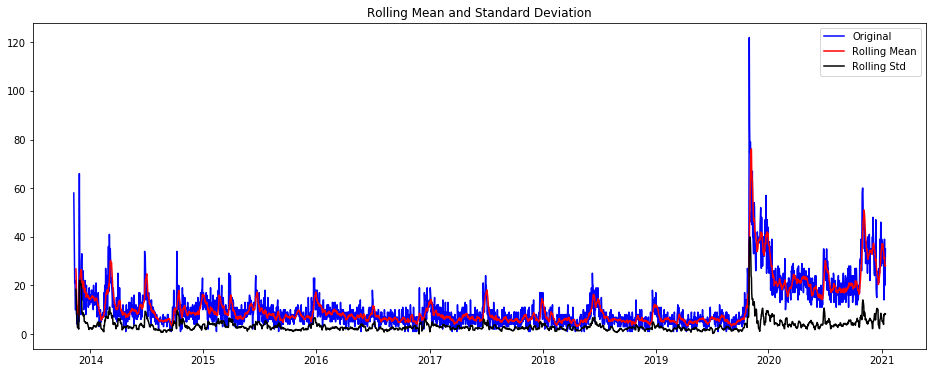

In [21]:
roll_mean = reviewcount['dailycountfilter'].rolling(window=8, center=False).mean()
roll_std = reviewcount['dailycountfilter'].rolling(window=8, center=False).std()

fig = plt.figure(figsize= (16,6))
plt.plot(reviewcount['dailycountfilter'], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label='Rolling Std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

-----

# Stationarity Tests

### Summary Statistics

Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

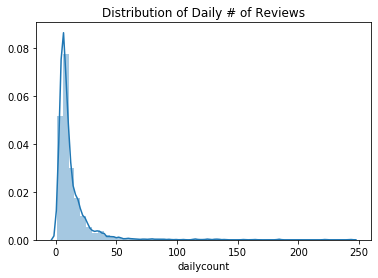

In [29]:
sns.distplot(reviewcount['dailycount'])
plt.title('Distribution of Daily # of Reviews')

In [31]:
X = reviewcount['dailycount'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=10.279052, mean2=15.719204
variance1=90.387726, variance2=438.074941


Text(0.5, 1.0, 'Distribution of Daily # of Reviews')

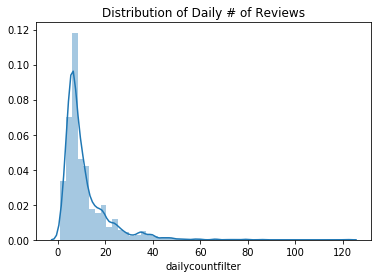

In [28]:
sns.distplot(reviewcount['dailycountfilter'])
plt.title('Distribution of Daily # of Reviews')

In [32]:
X = reviewcount['dailycountfilter'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(),X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=9.218654, mean2=13.186305
variance1=31.431548, variance2=147.047731


### Dickey-Fuller Test

In [26]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(reviewcount['dailycount'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-4.899112181992308, 3.50133966639758e-05, 27, 2587, {'1%': -3.4328802668982084, '5%': -2.862657875000973, '10%': -2.5673650853551155}, 18845.897585169278)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -4.899112
p-value                           0.000035
#Lags Used                       27.000000
Number of Observations Used    2587.000000
Critical Value (1%)              -3.432880
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


In [25]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(reviewcount['dailycountfilter'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print('----------------------------------')
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

(-3.135547647846026, 0.02403192241006772, 28, 2586, {'1%': -3.4328812463201746, '5%': -2.8626583075270813, '10%': -2.5673653156355627}, 15133.539854101033)
----------------------------------
Results of Dickey-Fuller test: 

Test Statistic                   -3.135548
p-value                           0.024032
#Lags Used                       28.000000
Number of Observations Used    2586.000000
Critical Value (1%)              -3.432881
Critical Value (5%)              -2.862658
Critical Value (10%)             -2.567365
dtype: float64


### Looking at ACF and PACF

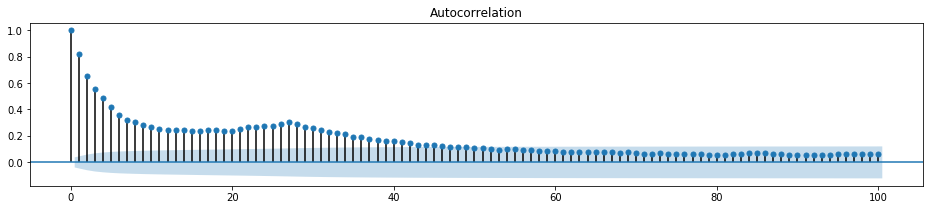

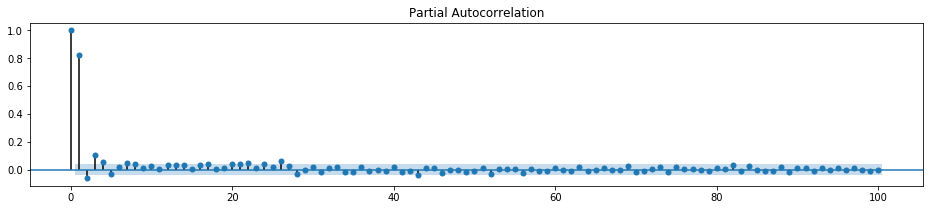

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycount'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycount'], ax=ax, lags=100);

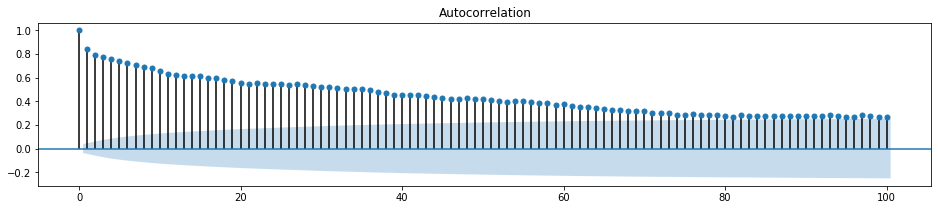

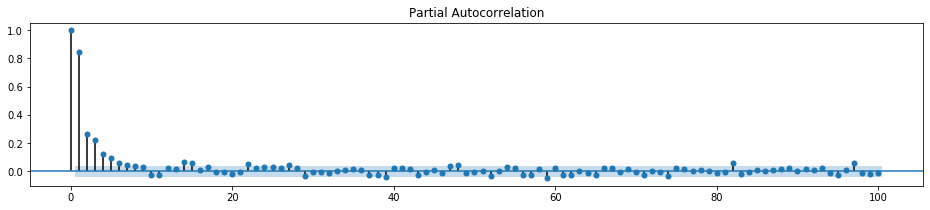

In [38]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(reviewcount['dailycountfilter'], ax=ax, lags=100);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(reviewcount['dailycountfilter'], ax=ax, lags=100);

------

In [39]:
# Import ARMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Instantiate an AR(1) model to the simulated data
mod_arma = ARMA(reviewcount['dailycount'], order=(1,0))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [40]:
res_arma = mod_arma.fit()

In [41]:
# Print out summary information on the fit
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:             dailycount   No. Observations:                 2615
Model:                     ARMA(1, 0)   Log Likelihood               -9567.335
Method:                       css-mle   S.D. of innovations              9.388
Date:                Sun, 24 Jan 2021   AIC                          19140.670
Time:                        18:24:50   BIC                          19158.277
Sample:                             0   HQIC                         19147.048
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.1168      1.035     12.669      0.000      11.088      15.146
ar.L1.dailycount     0.8230      0.011     73.813      0.000       0.801       0.845
                            

In [42]:
# Print out the estimate for the constant and for theta
print(res_arma.params)

const               13.116764
ar.L1.dailycount     0.822980
dtype: float64
